In [ ]:
# import modules, prep spotipy oauth
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import cred
import time
import random
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math


scope = "playlist-read-private, playlist-modify-public, user-read-private, user-top-read, user-library-read"
auth_manager = SpotifyOAuth(client_id=cred.client_id, client_secret=cred.client_secret, redirect_uri='http://127.0.0.1:8080', scope=scope)
sp = spotipy.Spotify(auth_manager=auth_manager, requests_timeout=10, retries=5)

user_id = sp.current_user()['id']
user_country = sp.current_user()['country']
username = sp.current_user()['display_name']
if sp.current_user()['explicit_content']['filter_enabled'] or sp.current_user()['explicit_content']['filter_locked']:
  user_explicit = False
else:
  user_explicit = True


In [ ]:
# Functions
def get_user_playlist_ids():
  '''
  Collects a list of user playlist dictionaries and the Spotify ID for each of them.
  '''
  playlists_lst =[]
  ids = []
  offset = 0
  while True:
      playlists = sp.current_user_playlists(offset=offset)
      if len(playlists['items']) == 0:
          break
      for playlist in playlists['items']:
          playlists_lst.append(playlist)
      offset = offset + len(playlists['items'])
      time.sleep(0.0001) 
  
  for playlist in playlists_lst:
      ids.append(playlist['id'])
  return ids, playlists_lst

def get_saved_tracks():
  '''
  Gets a user's "liked" tracks
  '''
  ids = []
  print('I\'m starting to look at the user\'s saved tracks!!')
  offset = 0
  t1 = time.time()
  while True:
      track_ids = sp.current_user_saved_tracks(offset=offset)
      if len(track_ids['items']) == 0:
          break
      for track in track_ids['items']:
          if track['track'] == None:
              continue
          else:
              ids.append(track['track']['id'])
      offset = offset + len(track_ids['items'])
      time.sleep(0.0001)
  t2 = time.time()
  print(f'Hmmm... getting the liked tracks took {t2-t1} seconds!\n')
  return list(set(ids))

def get_playlist_names(playlists):
  '''
  Returns a list of a user's playlist titles when given a list of playlist ids
  '''
  names = []
  for playlist in playlists:
      name = sp.playlist(playlist)['name']
      names.append(name)
  return names

def get_song_ids_from_playlists(user, playlist_urls):
  '''
  Gets song ids from each of the songs in given playlist ids
  '''
  ids = []
  t1 = time.time()
  for i in range(len(playlist_urls)):
      offset = 0
      #playlist_name = get_playlist_names([playlist_urls[i]])
      print(f'I\'m grabbing saved songs from playlist number {i+1} out of {len(playlist_urls)}')
      while True:
          track_ids = sp.user_playlist_tracks(user=user, playlist_id=playlist_urls[i], offset=offset, fields ='items.track.id')
          #print(track_ids)
          #print(len(track_ids['items']))
          if len(track_ids['items']) == 0:
              break
          for track in track_ids['items']:
              if track['track'] == None:
                  continue
              else:
                  ids.append(track['track']['id'])
          offset = offset + len(track_ids['items'])
          time.sleep(0.0001)
  t2 = time.time()
  print(f'Getting song ids from all those playlists took {round(t2-t1, 2)} seconds!\n')
  return list(set(ids))

def get_recc_ids(list_seed_tracks, country):
  '''
  Gets ids for # recommended songs for each song in the seed tracks list
  '''
  print('Starting to collect recommendation ids.')
  if len(list_seed_tracks) > 150:
    print(f'Wow! I have {len(list_seed_tracks)*20} to make. This may take a while.\n')

  recc_ids = []
  #raw_recs = []
  t1 = time.time()
  for seed in list_seed_tracks:
    seed_to_use = []
    seed_to_use.append(seed)
    recs = sp.recommendations(seed_tracks=seed_to_use, limit = 20, country=country)
    #raw_recs.append(recs)
    #print(recs)
    for i in range(len(recs['tracks'])):
      track_id = recs['tracks'][i]['id']
      recc_ids.append(track_id)
    #print(len(recc_ids))
  set_ids = set(recc_ids) 
  t2 = time.time()
  print(f'Making and saving all of those recommendations took {round(t2-t1, 2)} seconds.\n')
  return list(set_ids)

def create_playlist(tracks):
  sp.user_playlist_create(user_id, 'your recommended songs', description='yay new songs!')
  user_playlists, y = get_user_playlist_ids()
  sp.user_playlist_add_tracks(user_id, user_playlists[0], tracks)
  return 'Your playlist has been created!'

def create_df(track_ids, in_lib):
  print(f'{len(track_ids)} observations to make!')
  data = []

  for i in range(len(track_ids)):
    # Get raw data for track
    try:
      track = sp.track(track_ids[i])
      features = sp.audio_features(track_ids[i])
      analysis = sp.audio_analysis(track_ids[i])
      artist_uri = track['album']['artists'][0]['uri']
      artist = sp.artist(artist_uri)
    except:
      print(f'skipped one ({in_lib})!')
      continue

    # Extract relevant data
    observation = [
      track['uri'], 
      track['name'],
      in_lib,
      artist['followers']['total'],
      artist['genres'],
      artist['popularity'],
      track['album']['release_date'][0:4], 
      len(track['artists']),
      round(track['duration_ms']/60000, 4),
      track['popularity'],
      features[0]['danceability'],
      features[0]['energy'],
      features[0]['key'],
      analysis['track']['key_confidence'],
      features[0]['loudness'],
      features[0]['mode'],
      analysis['track']['mode_confidence'],
      features[0]['speechiness'],
      features[0]['acousticness'],
      features[0]['instrumentalness'],
      features[0]['liveness'],
      features[0]['valence'],
      features[0]['tempo'],
      analysis['track']['tempo_confidence'],
      features[0]['time_signature'],
      analysis['track']['time_signature_confidence'],
      analysis['track']['num_samples'],
      len(analysis['bars']),
      len(analysis['beats']),
      len(analysis['sections']),
      len(analysis['segments']), # for each segment, there is a list of pitches and timbre!
      len(analysis['tatums'])
    ]

    # Add observation to total dataset
    data.append(observation)
    time.sleep(0.0000001)
    
  # Create final data frame with proper column names
  df = pd.DataFrame(data, columns=[
    'uri', 'track_name', 'in_library', 'artist_followers', 'artist_genres', 'artist_popularity', 'release_date', 
    'nartists', 'duration_m', 'track_popularity', 'danceability', 'energy',
    'key', 'key_conf', 'loudness', 'mode', 'mode_conf', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'tempo_conf', 'time_sig', 'time_sig_conf', 'nsamples', 'nbars',
    'nbeats', 'nsections', 'nsegments', 'ntatums'
  ])

  return df

def numeric_df(combined_df):
  numeric_df = combined_df.select_dtypes(include = 'number')
  numeric_df.drop(labels = ['key_conf',  'tempo_conf', 'time_sig_conf', 'mode_conf', 'key', 'mode', 'time_sig'], axis = 1)
  return numeric_df

def df_manage(reccs, saved):
  recc_df = create_df(reccs, 0) # df of recommendations
  saved_df = create_df(saved, 1) # df of songs in library
  combined_df = pd.concat([recc_df, saved_df], ignore_index = True) # the previous two combined
  numeric_only = numeric_df(combined_df)
  return recc_df, saved_df, combined_df, numeric_only

def ml_df(full_df, vars):
  new_vars = ['in_library', *vars]
  small_df = full_df[new_vars]
  kmeans_df = small_df.drop('in_library', axis = 1)
  return small_df, kmeans_df

def count_predict(kmeans, recc_df, saved_df, vars):

  st_reccs = StandardScaler().fit_transform(recc_df[vars])
  st_saved = StandardScaler().fit_transform(saved_df[vars])

  # Predict clusters for recommendations
  recc_predictions = kmeans.predict(st_reccs)
  # Predict clusters for saved tracks
  saved_predictions = kmeans.predict(st_saved)

  # Set counts for all recc clusters to 0 (ensures that all clusters are present)
  initial_recc_counts = {}
  for i in range(0, clusters):  
    initial_recc_counts[i] = 0

  # Create a counter and add in predicted cluster counts for recommendations
  cluster_recc_counts = Counter(initial_recc_counts)
  cluster_recc_counts.update(recc_predictions)

  # Set counts for all saved clusters to 0 (ensures that all clusters are present)
  initial_saved_counts = {}
  for i in range(0, clusters):  
    initial_saved_counts[i] = 0

  # Create a counter and add in predicted cluster counts for saved tracks
  cluster_saved_counts = Counter(initial_saved_counts)
  cluster_saved_counts.update(saved_predictions)

  # Create new dict with percentages of songs in library that are in each of the clusters
  cluster_prop = {}
  for item in cluster_saved_counts:
    cluster_prop[item] = cluster_saved_counts[item] / saved_df.shape[0]

  n_to_recc = {}
  for item in cluster_prop:
    n_to_recc[item] = round(cluster_prop[item]*30, 7)
  
  return recc_predictions, cluster_recc_counts, cluster_saved_counts, cluster_prop, n_to_recc

def add_cluster(recc_data, saved_data, clusters):
  recc_data['cluster'] = clusters
  saved_data['cluster'] = max(clusters) + 1
  new_combined = pd.concat([recc_data, saved_data], ignore_index = True)
  return new_combined

def silhouette(scaled_og_data):
  range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

  for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_og_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaled_og_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_og_data, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_og_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
      )

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
      scaled_og_data[:, 0], scaled_og_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
      centers[:, 0],
      centers[:, 1],
      marker="o",
      c="white",
      alpha=1,
      s=200,
      edgecolor="k",
    )

    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
      "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
      % n_clusters,
      fontsize=14,
      fontweight="bold",
    )

  plt.show()

def diagnostics(scaled_data, fit_data, vars):
  
  if len(vars) == 2:
    sns.scatterplot(data = fit_data, x = vars[0], y = vars[1])
    plt.show()

    sns.scatterplot(data = fit_data, x = vars[0], y = vars[1], hue = 'cluster', palette = 'Spectral')
    plt.show()
  else:
    sns.pairplot(data = fit_data, vars = vars, hue = 'cluster', palette = 'Spectral')
    plt.show()
    silhouette(scaled_data)

  distortions = []
  for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)
  
  fig = plt.figure(figsize=(15, 5))
  plt.plot(range(2, 15), distortions)
  plt.grid(True)
  plt.title('Elbow curve')

In [ ]:
# Get all playlist ids and all complete playlist information
playlist_ids, raw_playlists = get_user_playlist_ids()
print(f'Cool! You have {len(playlist_ids)} playlists in your library!')

#playlist_names = get_playlist_names(playlist_ids)

# Extract playlist 1 for testing
#testing_playlist = [playlist_ids[0]]

# Extract all playlists except holiday and classical/soundtracks
testing_playlists = playlist_ids[7:-19]

# Get the song ids for all tracks in the selected playlist(s)
in_lib_ids = get_song_ids_from_playlists(user_id, testing_playlists)
print(f'Whoa...you have {len(in_lib_ids)} songs in your library (using the playlists provided).')

recc_ids = get_recc_ids(in_lib_ids, user_country)
#about 9.5 mins

In [ ]:
# Build data frames
# ASSUMING 20 RECOMMENDATIONS PER SONG IN LIBRARY

recc_df, saved_df, combined_df, numeric_df = df_manage(recc_ids, in_lib_ids)
#286 minutes

In [ ]:
# Reduce data frames to select variables, remove in_lib for kmeans
variables = ['liveness', 'acousticness', 'energy', 'valence', 'loudness']

small_df, kmeans_df = ml_df(combined_df, variables)

In [31]:
# Scale/normalize all data, fit kmeans

scaled_data = StandardScaler().fit_transform(kmeans_df)

clusters = 4
km = KMeans(n_clusters=clusters, random_state = 10, init = 'k-means++').fit(scaled_data)

In [32]:
# Find clusters and proportions for recommended songs

recc_pred, recc_count, saved_count, saved_prop, nto_recc = count_predict(km, recc_df, saved_df, variables)

In [33]:
new_nto_recc = {}
for k, v in nto_recc.items():
  new_nto_recc[k] = math.ceil(v)
print(new_nto_recc)

{0: 4, 1: 11, 2: 7, 3: 10}


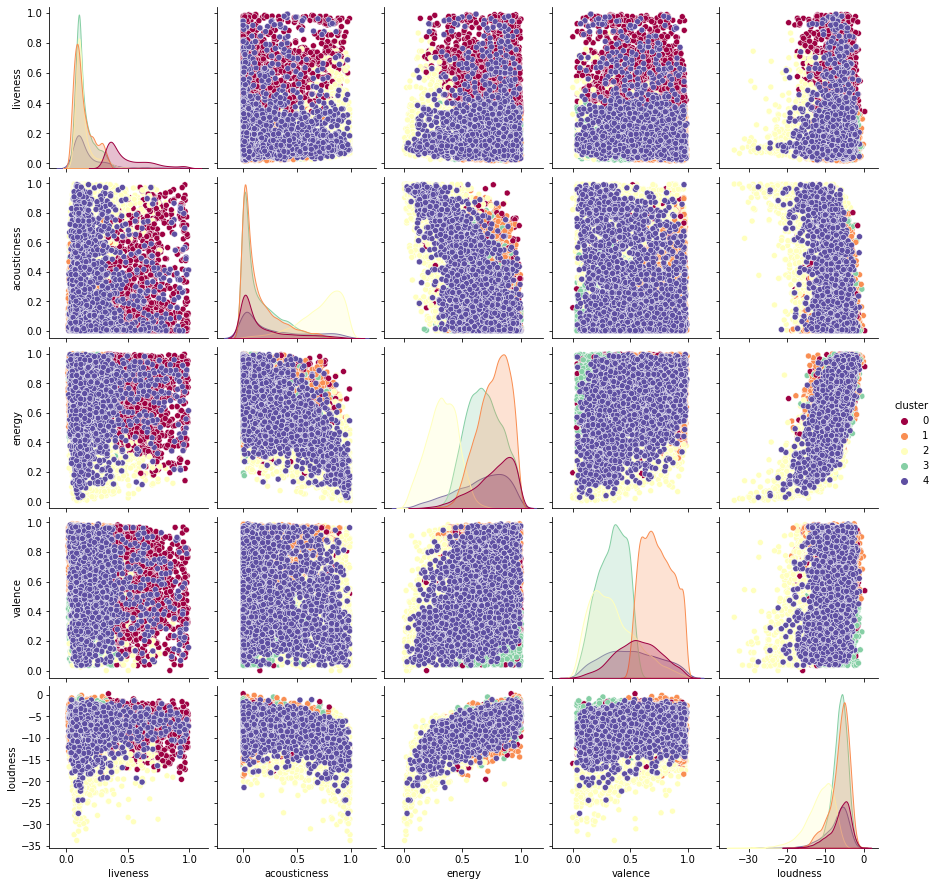

For n_clusters = 2 The average silhouette_score is : 0.3686022937213464
For n_clusters = 3 The average silhouette_score is : 0.2965214205630095
For n_clusters = 4 The average silhouette_score is : 0.25435809545252763
For n_clusters = 5 The average silhouette_score is : 0.2276065752081525
For n_clusters = 6 The average silhouette_score is : 0.23057990034086778
For n_clusters = 7 The average silhouette_score is : 0.23459464607456146
For n_clusters = 8 The average silhouette_score is : 0.21358928523038145
For n_clusters = 9 The average silhouette_score is : 0.2196780699513493
For n_clusters = 10 The average silhouette_score is : 0.2227815485065696


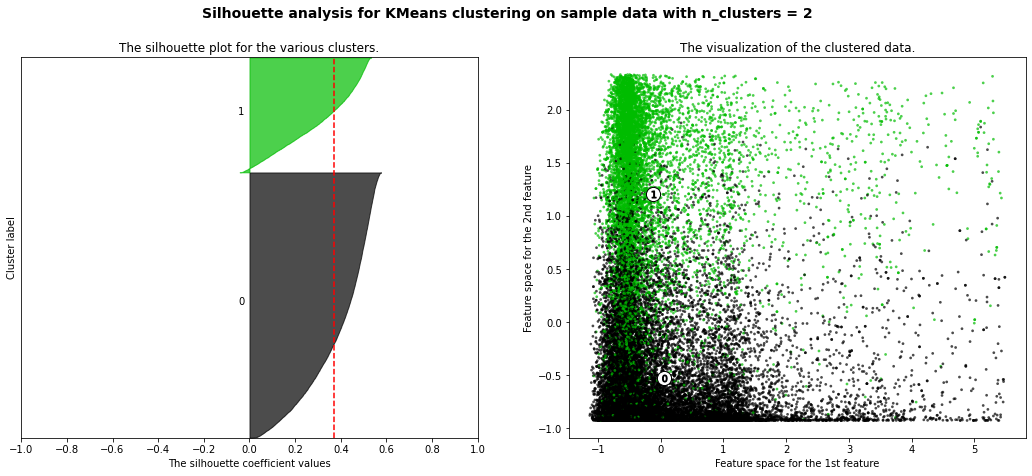

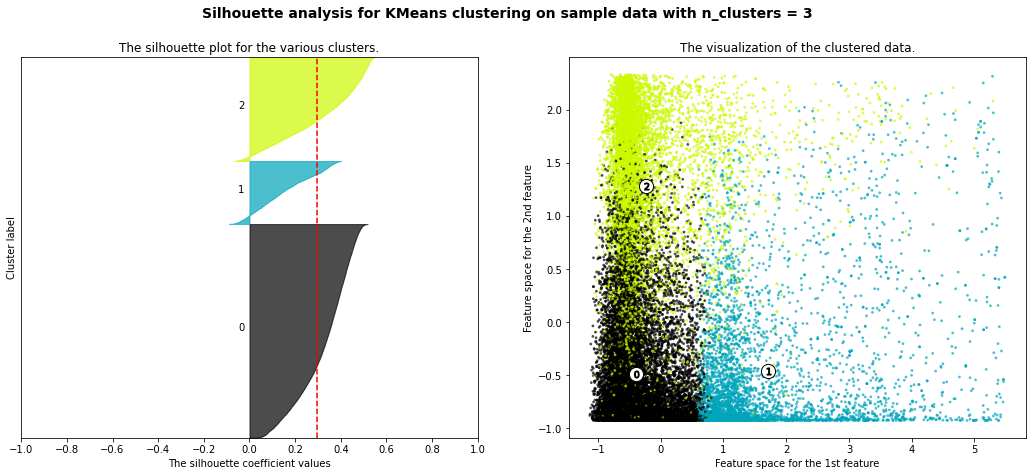

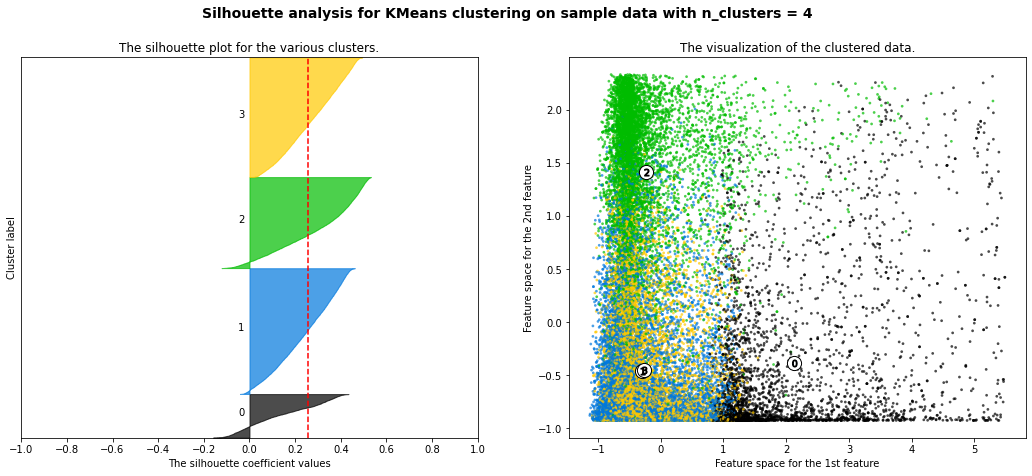

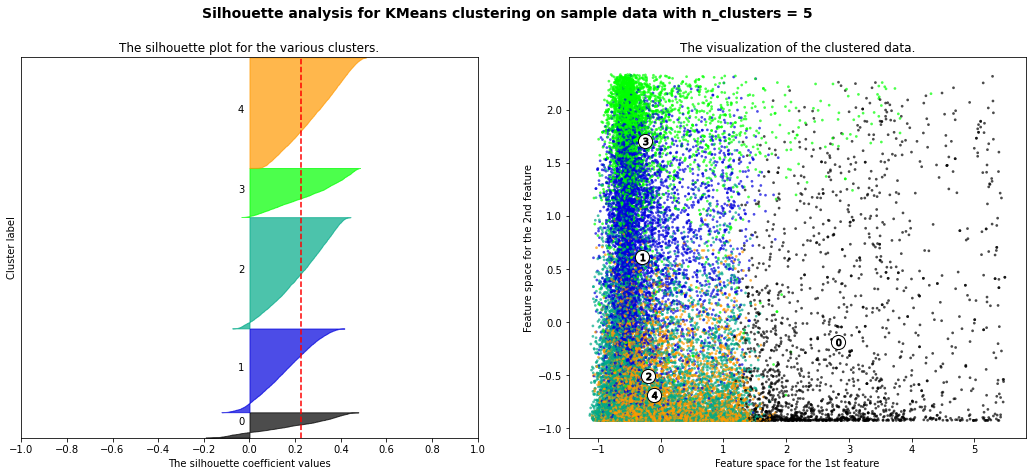

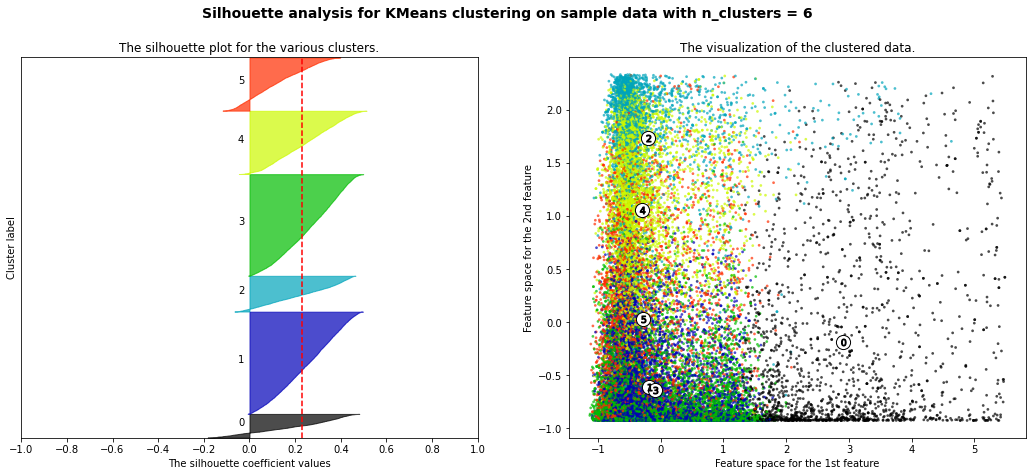

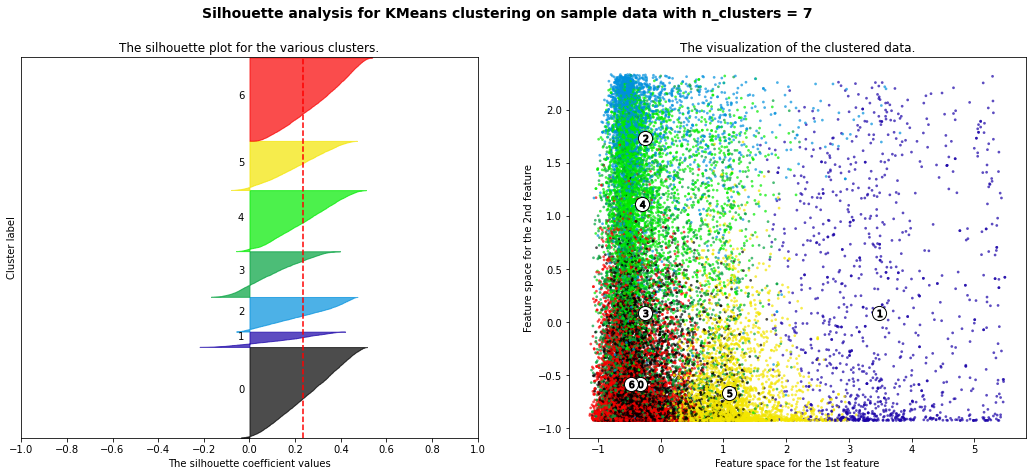

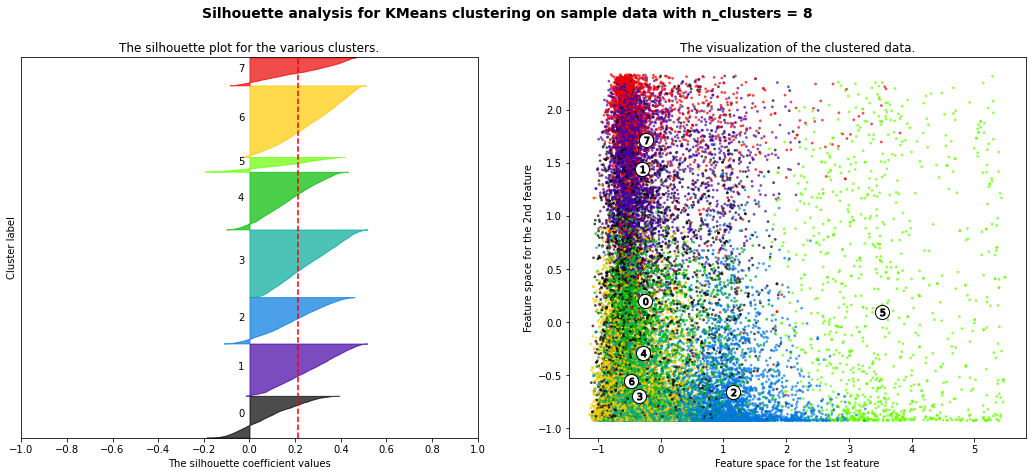

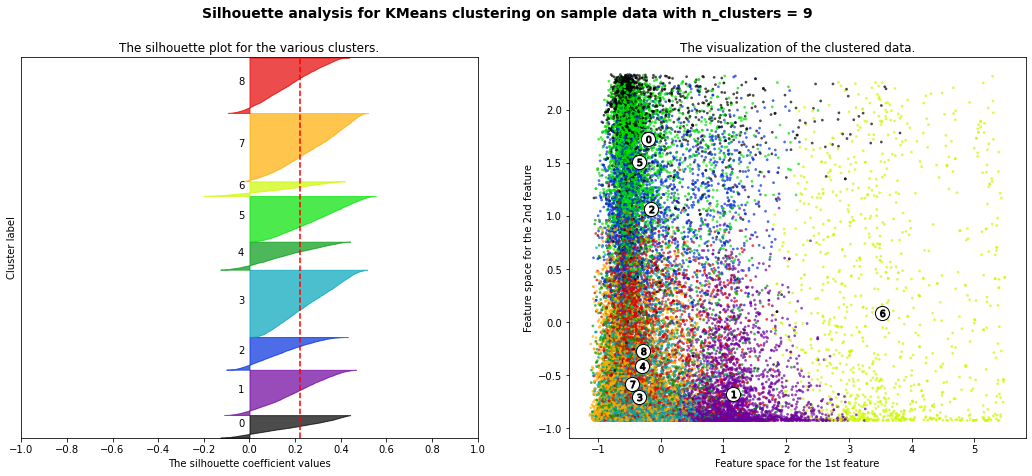

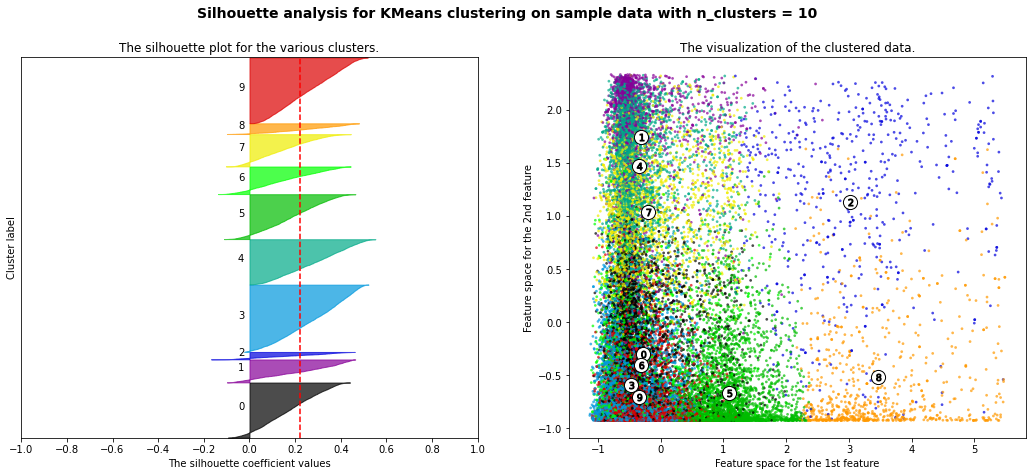

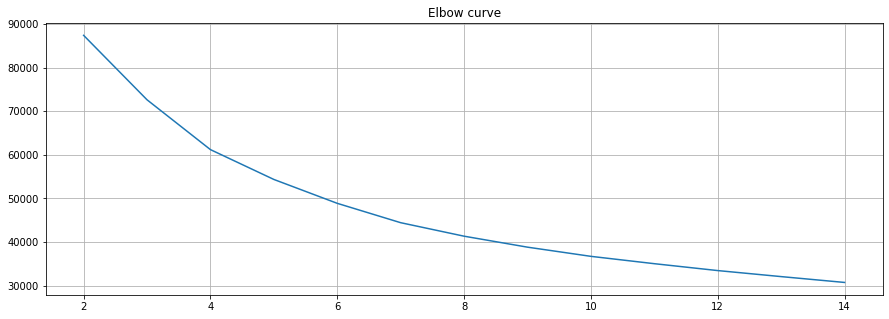

In [34]:
# Add column to df with predicted cluster, print useful plots

ncombined = add_cluster(recc_df, saved_df, recc_pred)
diagnostics(scaled_data, ncombined, variables)

In [ ]:
# Recommendations

def group1(og_reccs, in_lib_tracks):

  random.shuffle(og_reccs)

  if len(og_reccs) <= 30:
    group1 = og_reccs
  else:
    group1 = []
    for i in range(len(og_reccs)):
      if og_reccs[i] not in in_lib_tracks:
        group1.append(og_reccs[i])
      if len(group1) == 30:
        break

  return group1

def group2(to_recc_counts, clustered_data, in_lib_tracks):
  group2 = []
  
  for cluster in to_recc_counts.keys():
    one_cluster = clustered_data[clustered_data.cluster.eq(cluster)] # Select one cluster
    uris = list(one_cluster['uri']) # Select only uris
    reccs = random.sample(uris, k = to_recc_counts[cluster]) # take a random sample of the correct size
    for i in range(len(reccs)):
      group2.append(reccs[i]) # Append uris to group2

  # Remove any tracks already in library
  for i in range(len(group2)):
    if group2[i] in in_lib_tracks:
      group1.remove(group2[i])
  return group2

#create_playlist(group1(recc_ids, in_lib_ids))
create_playlist(group2(new_nto_recc, ncombined, in_lib_ids))

In [ ]:
# outlier detection
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat_iso = iso.fit_predict(scaled_data)
obs_iso = np.where(yhat_iso == -1)[0]

from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
yhat_lof = lof.fit_predict(scaled_data)
obs_lof = np.where(yhat_lof == -1)[0]

from sklearn.svm import OneClassSVM
ee = OneClassSVM(nu=0.01)
yhat_ee = ee.fit_predict(scaled_data)
obs_ocs = np.where(yhat_ee == -1)[0]

common_outliers = sorted(set(obs_iso) & set(obs_lof) & set(obs_ocs))
print(common_outliers)
recc_outliers = []
for item in common_outliers:
  if combined_df.iloc[item]['in_library'] == 0:
    recc_outliers.append(item)

In [ ]:
# analysis without outliers
new_recc_df = recc_df.drop(recc_outliers, axis = 0, inplace = False)
new_combined_df = pd.concat([new_recc_df, saved_df], ignore_index = True)

new_small_df, new_kmeans_df = ml_df(new_combined_df, variables)

new_scaled_data = StandardScaler().fit_transform(new_kmeans_df)
new_kmeans = KMeans(n_clusters=clusters, random_state = 10).fit(new_scaled_data)

new_recc_pred, new_recc_count, new_saved_count, new_saved_prop, new_nto_recc = count_predict(new_kmeans, new_recc_df, saved_df, variables)

new_combined = add_cluster(new_recc_df, saved_df, new_recc_pred)
diagnostics(new_scaled_data, new_combined, variables)
